## Purpose
We want to estimate the likelihood edges occuring in time slice (say a minute) between two nodes in a graph. One way is to do randomly initialize the node vectors and assume that the dot product of the node vectors is proportional to the likelihood. Then we use SGD to maximise the likelihood of the true samples in the training graph. Nodes that have edges between them will be mapped to similar regions in the vector space. We are still ignoring the temporal aspect here. 

However if the graph is very large, SGD may be too slow and may require a lot of time and compute. Can we try any analytical way to estimate this likelihood? What we are interested is low likelihood edges within a time slice which could represent anamolies. 

## Approach
Lets try to arrive at a `score` which will indicate the likelihood of the edge given the historical graph data. 

Lets use the historical data to simply compute the number of edges between two nodes or a grouping of nodes (if we want to reduce the number nodes)

In [19]:
import pandas as pd
import numpy as np
import scipy

from matplotlib import pyplot as plt
import seaborn as sns

edge_count = pd.DataFrame({
    'src': ['n1', 'n2', 'n3', 'n101', 'n102'],
    'dst': ['n0', 'n0', 'n0', 'n0', 'n0'],
    'hist_count': [40, 50, 10, 2, 1]
})
edge_count.head()

,src,dst,hist_count
0,n1,n0,40
1,n2,n0,50
2,n3,n0,10
3,n101,n0,2
4,n102,n0,1


So when we detect an edge in the test data between nodes with low `hist_count` in the training data, we want the `score` to be high. We need a some kind of weighting function learnt from the training which we can apply to the test data. 

A linear weighting function is not of much help as we want to point out the anamolies more prominantly. We want much higher weights for the low frequency edges and lower weights for the high frequency ones. 

We also want a normalized score, so that it can be used across low degree nodes and high degree nodes without any changes. In other words, we are looking to convert the edge counts in to probability distribution for each dst node. 

### Softmax
Softmax converts samples into a probility distribution, as $e^x$ is always positive and sum of outputs will equal to 1. 

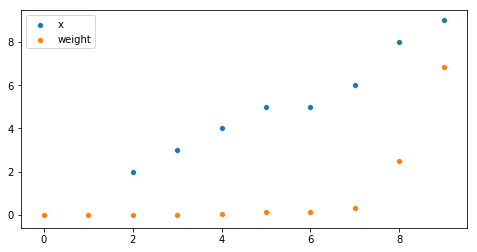

In [58]:
x = sorted(np.random.randint(0, 10, size=10))
# y_scipy = scipy.special.softmax(x)

# lets calculate y without scipy
sum_exp = np.sum(np.exp(x))
y = np.exp(x)/sum_exp

fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(range(len(x)), x, ax=ax, label='x')
sns.scatterplot(range(len(x)), y*10, ax=ax, label='weight')
# sns.scatterplot(range(len(x)), y_scipy, ax=ax)

But softmax amplifies the value of the higher valued outputs relative to others. What we want is the opposite of that. 

So lets try to use the opposite of softmax

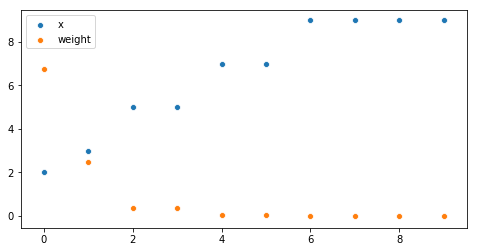

In [69]:
x = np.sort(np.random.randint(0, 10, size=10))

# for smoothing
x += 1

s = np.sum(np.exp(x * -1))
y = np.exp(x * -1)/s


# y = np.exp(x * -1)/sum_exp

fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(range(len(x)), x, ax=ax, label='x')
sns.scatterplot(range(len(x)), y * 10, ax=ax, label='weight')

That looks better as the frequency edges get a high weight 

### Apply

Lets learn the weights from our initial training graph

In [74]:
def weight_func(n):
    return np.exp(n * -1)
    
s = np.sum(weight_func(edge_count.hist_count))
weight_dict = {edge_count.iloc[idx]['src']: weight_func(edge_count.iloc[idx]['hist_count'])/s for idx in range(edge_count.shape[0])}
weight_dict

{'n1': 8.441666744174323e-18,
 'n2': 3.8325107726381843e-22,
 'n3': 9.021165708731927e-05,
 'n101': 0.26891715971871394,
 'n102': 0.7309926286241988}

In [84]:
# node, edge_count during the test time slice
test_dict = {
    'n1': 10,
    'n20': 3,
    'n101': 4
}


In [87]:
weight_func(0)/s

1.9870439791266707

In [86]:
weight_func(1)

0.36787944117144233

In [89]:
test_scores = [c * weight_dict.get(n, weight_func(0)/s) for n, c in test_dict.items()]
test_scores

[8.441666744174323e-17, 5.961131937380012, 1.0756686388748558]

In [91]:
total_score = sum(test_scores)
total_score

7.036800576254867